In [1]:
import numpy as np
import os
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nturn = 2048
npt = 64
std = 0.05
Espread = 2.0e-3

# Read MLI input for settings

In [3]:
elems,latticeList,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4.optimized')
elems[2].driftexact=0

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [4]:
energy=elems[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [5]:
elemList = []
for item in elems:
    if not item.elem in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)

In [6]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx


f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [7]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
#     data[:,5] = -bet0*data[:,5]*(1.0+0.5*data[:,5]/gam0**2-0.5*(bet0/gam0)**2*data[:,5]*data[:,5])
#     data[:,5] = -bet0*data[:,5]*(1.0+0.5*data[:,5]/gam0**2-0.5*(bet0/gam0)**2*data[:,5]*data[:,5])
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
#     data[:,5] = -data[:,5]/bet0-0.5*(data[:,5]/(bet0*gam0))**2-0.5*(data[:,5]/(bet0*gam0))**3*gam0
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [8]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

In [9]:
x=get_truncated_normal(sd=std,low=-2.0*std,upp=2.0*std,n=npt*5)
pData0=np.zeros([npt,6])
pData0[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData0[:,5] = pData0[:,5]/std*Espread
np.save('pDataNorm',pData0)

pDataIn = norm2MLI(pData0,sign=1)
np.savetxt('rays.in',pDataIn)

# Cmds

In [10]:
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
fin     =mli.getElem.fin

elemList = elemList + [raysin, dump, track, fin]

In [11]:
# labor = mli.buildLabor(['iotaline','mapout'])
# mli.writeInputfile(elemList,latticeList,labor)
# mli.run()

# Lattice

In [12]:
nlinsert=mli.getElem.nlinsert()

iotaline = latticeList[0]
iotaline.list.insert(0,nlinsert.name)
iotaline.list.append(dump.name)

elemList = elemList + [nlinsert]

# Labor

In [13]:
labor = mli.buildLabor(['iotaline','mapout','clear',raysin.name,track.name,str(nturn)+'*'+iotaline.name,'fin'])

#  Run

In [14]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out

In [15]:
mli.writeInputfile(elemList,latticeList,labor)

In [16]:
mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.1.log
TBT1 = getTBT(npt,nturn)
print(TBT1.shape)

(64, 2048, 6)


In [17]:
elems,dummy,dummy = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
elems[2].driftexact=0
elemList = []
for item in elems:
    if not item.name in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)
elemList = elemList + [raysin, dump, track, fin, nlinsert]

mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.0.log
TBT0 = getTBT(npt,nturn)
print(TBT0.shape)

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...
(64, 2048, 6)


In [18]:
elems,dummy,dummy = mli.readInputfile('mli.in.t3_iota_8_4_t0p4.GlobalDEsext.optimized')
elems[2].driftexact=0
elemList = []
for item in elems:
    if not item.name in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)
elemList = elemList + [raysin, dump, track, fin, nlinsert]

mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.2.log
TBT2 = getTBT(npt,nturn)
print(TBT2.shape)

(64, 2048, 6)


# Check invariants

In [19]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [20]:
Inv0 = getInvTBT(TBT0)
Inv1 = getInvTBT(TBT1)
Inv2 = getInvTBT(TBT2)

### Absolute

In [21]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
0.06021036692900008 0.11877514962824645
0.014858980419408745 0.02851811127611803
0.010914935372774017 0.02067628016753804


In [22]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
0.0012507496299055433 0.0024460503159448965
0.00017810240028640133 0.00035759197293099216
5.598874365678827e-05 0.00011042380538316543


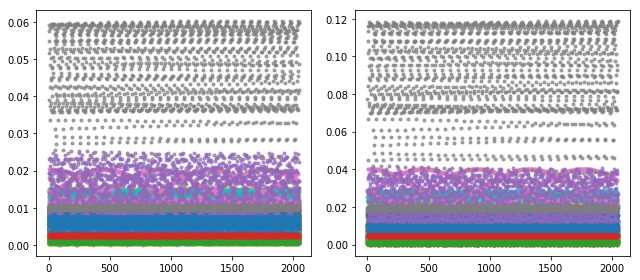

In [23]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

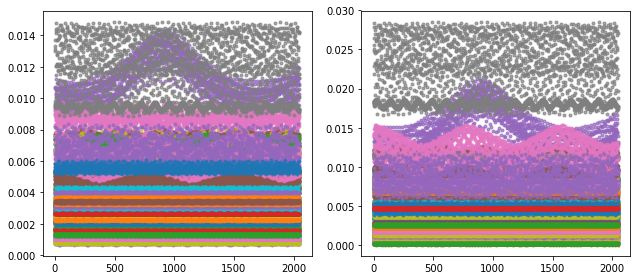

In [24]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

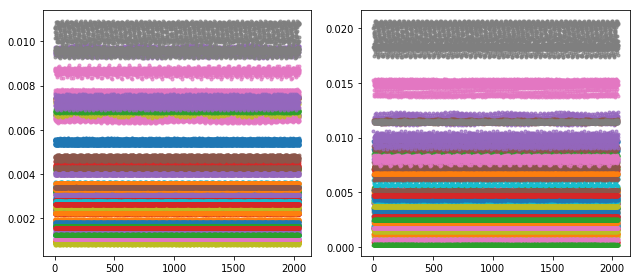

In [25]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

### Relative

In [26]:
for i in range(npt):
    Inv0[i,:,0] = Inv0[i,:,0]/Inv0[i,0,0].mean()-1.0
    Inv0[i,:,1] = Inv0[i,:,1]/Inv0[i,0,1].mean()-1.0
    Inv1[i,:,0] = Inv1[i,:,0]/Inv1[i,0,0].mean()-1.0
    Inv1[i,:,1] = Inv1[i,:,1]/Inv1[i,0,1].mean()-1.0
    Inv2[i,:,0] = Inv2[i,:,0]/Inv2[i,0,0].mean()-1.0
    Inv2[i,:,1] = Inv2[i,:,1]/Inv2[i,0,1].mean()-1.0

In [27]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
4.424803427606836 4.63910439146224
0.48895345387863154 0.8039524980624557
0.1491332021095646 0.19285369288701082


In [28]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
0.24262111877424108 0.3306437019598463
0.04277628060630001 0.07098672905963514
0.015113236928621473 0.024196408508685447


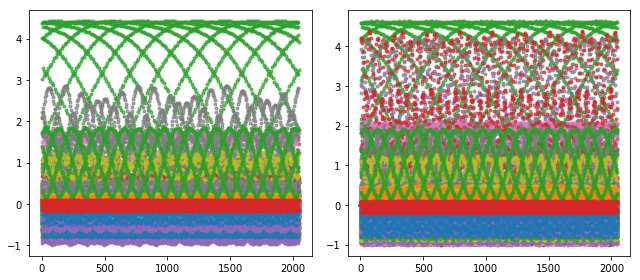

In [29]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

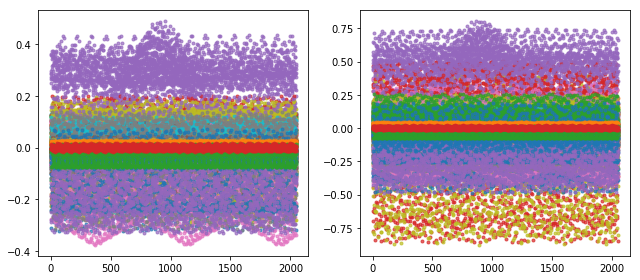

In [30]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

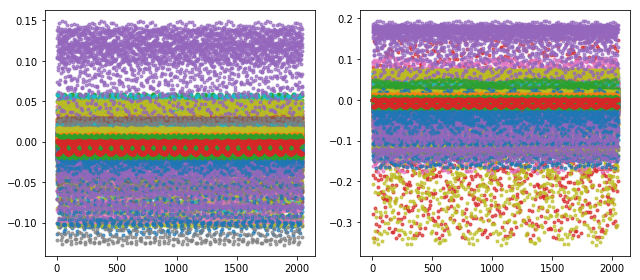

In [31]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()